# 資料匯入

台電2019-2022年3月29日電力供應資訊:

taipower-20190101-20211231.csv (https://data.gov.tw/dataset/24945)

taipower-20210101-20220329.csv (https://data.gov.tw/dataset/19995)







In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
path1 = 'taipower-20190101-20211231.csv'
path2 = 'taipower-20210101-20220329.csv'

df1 = pd.read_csv(path1, usecols=['日期', '備轉容量(萬瓩)'])
df2 = pd.read_csv(path2, usecols=['日期', '備轉容量(MW)'])

In [3]:
df1

,日期,備轉容量(萬瓩)
0,2019/1/1,255.73
1,2019/1/2,189.95
2,2019/1/3,189.16
3,2019/1/4,181.11
4,2019/1/5,190.27
...,...,...
1091,2021/12/27,376.80
1092,2021/12/28,325.30
1093,2021/12/29,280.70
1094,2021/12/30,437.60


In [4]:
df2

,日期,備轉容量(MW)
0,20210101,2767
1,20210102,2936
2,20210103,3037
3,20210104,3032
4,20210105,3067
...,...,...
448,20220325,3394
449,20220326,3277
450,20220327,3414
451,20220328,3069


In [5]:
df1['日期'] = pd.to_datetime(df1['日期'].astype(str), format='%Y-%m-%d')
df2['日期'] = pd.to_datetime(df2['日期'].astype(str), format='%Y-%m-%d')
df1['備轉容量(萬瓩)'] = df1['備轉容量(萬瓩)'].apply(lambda x: int(x*10))
df1.rename(columns={'備轉容量(萬瓩)': '備轉容量(MW)'}, inplace=True)

In [6]:
df = pd.concat([df1, df2]).drop_duplicates('日期', keep='last').reset_index(drop=True)
df.rename(columns={'日期': 'date', '備轉容量(MW)': 'operating_reserve(MW)'}, inplace=True)
df

,date,operating_reserve(MW)
0,2019-01-01,2557
1,2019-01-02,1899
2,2019-01-03,1891
3,2019-01-04,1811
4,2019-01-05,1902
...,...,...
1179,2022-03-25,3394
1180,2022-03-26,3277
1181,2022-03-27,3414
1182,2022-03-28,3069


# 資料概覽

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184 entries, 0 to 1183
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1184 non-null   datetime64[ns]
 1   operating_reserve(MW)  1184 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 18.6 KB


In [8]:
df.describe()

,operating_reserve(MW)
count,1184.000000
mean,3600.157939
std,995.745241
min,1437.000000
25%,3034.750000
50%,3461.500000
75%,4149.250000
max,7656.000000


In [9]:
df.isnull().sum()

date                     0
operating_reserve(MW)    0
dtype: int64

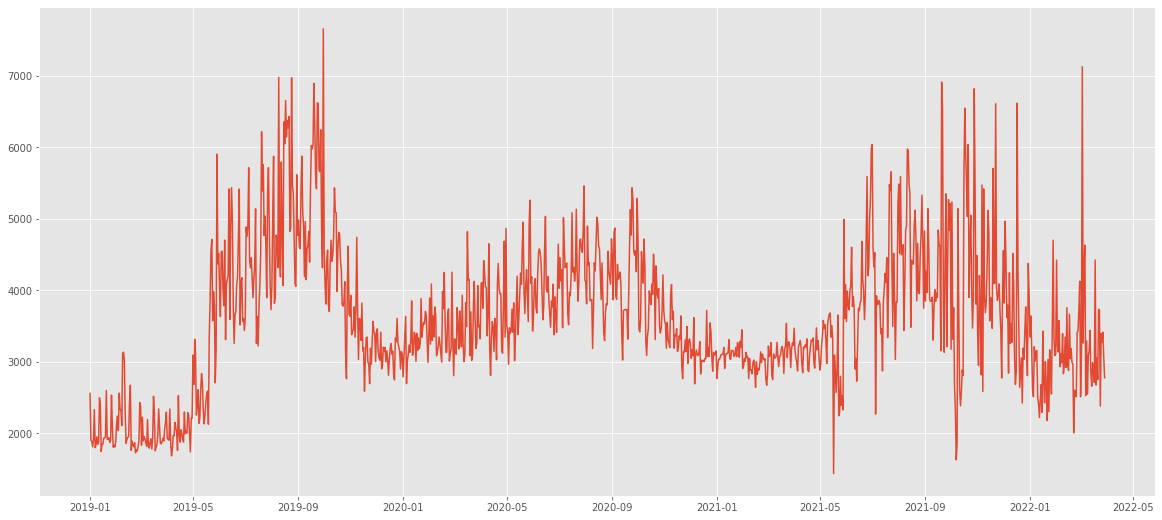

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 9))
plt.plot(df['date'], df['operating_reserve(MW)'])
plt.show()

# 前處理

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

def normalize(data):
  norm_arr = scaler.fit_transform(data)
  return pd.DataFrame(norm_arr)

def inverse_normalize(data):
  return scaler.inverse_transform(data)

In [12]:
df['operating_reserve(norm)'] = normalize( np.array(df['operating_reserve(MW)']).reshape(-1, 1) )
df

,date,operating_reserve(MW),operating_reserve(norm)
0,2019-01-01,2557,0.180093
1,2019-01-02,1899,0.074288
2,2019-01-03,1891,0.073002
3,2019-01-04,1811,0.060138
4,2019-01-05,1902,0.074771
...,...,...,...
1179,2022-03-25,3394,0.314681
1180,2022-03-26,3277,0.295868
1181,2022-03-27,3414,0.317897
1182,2022-03-28,3069,0.262422


# 模型構建

In [13]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [37]:
from keras.layers import Dense, Dropout, Flatten, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

def lstm_model():
    model = Sequential()
    model.add(LSTM(256, input_shape=(30, 1), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(30, activation='linear'))
    model.add(Dense(15, activation='linear'))
    model.compile(optimizer='rmsprop', loss=root_mean_squared_error, metrics=['accuracy'])
    model.summary()
    return model

In [28]:
model = lstm_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 256)           264192    
                                                                 
 lstm_5 (LSTM)               (None, 30, 256)           525312    
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            257       
 tributed)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 30)                0         
                                                                 
 dense_7 (Dense)             (None, 30)                930       
                                                                 
 dense_8 (Dense)             (None, 15)                465       
                                                      

In [16]:
def generate_train_data(df):
    x_train, y_train = [], []
    for i in range(df['date'].shape[0] - 45):
        y_train.append( np.array(df['operating_reserve(norm)'].iloc[i+30:i+45]) )
        x_train.append( np.array(df['operating_reserve(norm)'].iloc[i:i+30]) )
    return np.array(x_train), np.array(y_train)

In [30]:
x_train, y_train = generate_train_data(df)
callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
history = model.fit(x_train, y_train, epochs=300, batch_size=5, validation_split=0.1, callbacks=[callback], shuffle=True)

Epoch 1/300
205/205 [==============================] - 2s 8ms/step - loss: 0.1011 - accuracy: 0.0722 - val_loss: 0.1288 - val_accuracy: 0.0702
Epoch 2/300
205/205 [==============================] - 2s 8ms/step - loss: 0.1004 - accuracy: 0.0741 - val_loss: 0.1274 - val_accuracy: 0.0263
Epoch 3/300
205/205 [==============================] - 2s 8ms/step - loss: 0.0989 - accuracy: 0.0654 - val_loss: 0.1255 - val_accuracy: 0.0789
Epoch 4/300
205/205 [==============================] - 2s 8ms/step - loss: 0.0981 - accuracy: 0.0556 - val_loss: 0.1234 - val_accuracy: 0.0789
Epoch 5/300
205/205 [==============================] - 2s 9ms/step - loss: 0.0974 - accuracy: 0.0898 - val_loss: 0.1242 - val_accuracy: 0.0789
Epoch 6/300
205/205 [==============================] - 2s 8ms/step - loss: 0.0967 - accuracy: 0.0722 - val_loss: 0.1349 - val_accuracy: 0.0702
Epoch 7/300
205/205 [==============================] - 2s 9ms/step - loss: 0.0967 - accuracy: 0.0820 - val_loss: 0.1261 - val_accuracy: 0.0789

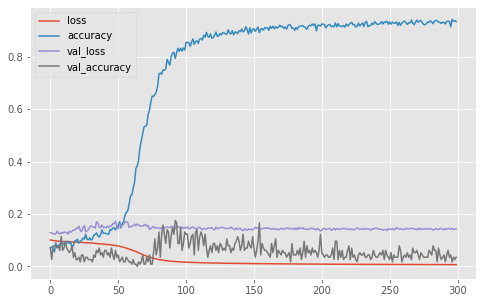

In [31]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [39]:
model.save('lstm.h5')

# 使用模型

In [33]:
import pandas as pd
import numpy as np
from keras.models import load_model

model = load_model('lstm.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [34]:
df_row_count = df['date'].shape[0]
df_test = normalize( np.array(df['operating_reserve(MW)'].iloc[df_row_count-30:df_row_count]).reshape(-1, 1) )
y_pred = inverse_normalize( model.predict(np.array(df_test).reshape((1,30,1))) )
print(y_pred)

[[4330.0034 3884.8918 4035.513  3921.0632 3549.451  3458.77   3677.8171
  4012.5005 3612.6262 3608.7224 3990.4004 3823.2192 3768.7698 3693.912
  3722.6729]]


In [40]:
submission = pd.DataFrame({
        'date': df['date'].iloc[df_row_count-15:df_row_count].apply( lambda x: (x+timedelta(days=15)).strftime("%Y%m%d") ),
        'operating_reserve(MW)': np.array(np.round(y_pred[0]), dtype=int)
    })
submission.to_csv('submission.csv', index=False)
submission

,date,operating_reserve(MW)
1169,20220330,4330
1170,20220331,3885
1171,20220401,4036
1172,20220402,3921
1173,20220403,3549
1174,20220404,3459
1175,20220405,3678
1176,20220406,4013
1177,20220407,3613
1178,20220408,3609
